

<p style="text-align: center"><i> "We have met the enemy, and he is us" - Walt Kelly </i></p>


It has long been noted that investors - individual and institutional - tend to be their own worst enemies.  They have an uncanny ability to buy stocks near market tops and sell near market bottoms.  As a consequence, _investor returns_, in aggregate, have a tendency to significantly lag _investment returns_ in aggregate since investors are less invested on the way up than on the way down.  

As an aside, I've always held the view that the observed causality is backwards - markets top _because_ everyone has piled in, and markets bottom _because_ everyone has pulled the rip cord, but I digress...

Back in 1994, a research firm named DALBAR made a name for themselves by attempting to quantify the gap between average investor returns and average investment returns, which they termed the "behavior gap".  To do this, they used ICI data to track inflows and outflows of investor capital to mutual funds so they could estimate how much an average _investor_ within any given investment was likely to perform.  

Results were jaw dropping.  DALBAR estimated the "behavior gap" to be more than 4% per year, meaning that the average investor earned less than _half_ of the average investment.  You can read the most recent annual update to DALBAR's report [here in the Quantitative Analysis of Investor Behavior report](https://2wmko64dug4x3dv4oh97ijl9-wpengine.netdna-ssl.com/wp-content/uploads/2018/04/2018-QAIB-Report_FINAL.pdf).  

A number of major flaws in the DALBAR methodology [have been pointed out](https://www.kitces.com/blog/does-the-dalbar-study-grossly-overstate-the-behavior-gap-guest-post/) by critics.  Without wading too far into this debate, I do believe that the critics make a strong case that the DALBAR methodology is flawed.  

In this post, I'm going to take a somewhat different approach to estimating average *investor returns* and average *investment returns*.  I will first propose a straight-forward and transparent set of formulas to estimate behavior gap in a way that fixes some of the major problems with DALBAR.  This method will rely on ETF data which provide *daily* fund flows (the DALBAR study uses mutual funds, which are quickly becoming less relevant than ETFs).

Then, I'll use this framework to estimate the behavior gap in different market sectors and draw some conclusions about the true "behavior gap" within ETF investors.  

As usual, I'm displaying the code used to reach this analysis for those who wish to replicate it - or audit the reasoning.  If you'd like to experiment with the below code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/investor_flows.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>

_Note that a few lines of this code calls on my proprietary price data libraries so you'll need to replace with connections to your datafeed of choice._  


## Step 1: Load Data
First, I'll define the functions needed to load and split/dividend adjust the ETF price data, as well as the daily shares outstanding data (aka "so").  This shares outstanding data is critical because it allows us to infer the daily capital flows in/out of the funds.  


### A Note About Fund Flows
A quick word about ETF fund flow data.  I've found [this article](https://www.fidelity.com/learning-center/investment-products/etf/primer-on-etf-valuation) useful as a primer on the mechanics of ETFs and associated data.  

Unlike most other securities, ETFs are continuously being created and redeemed in response to investor demand, via "authorized participant" intermediaries.  ETF sponsors (iShares, Vanguard, etc...) publish daily several values other than closing market price, including net asset value, total cash, and shares outstanding - which is of particular interest to us.

"Shares outstanding" is what it sounds like - the total number of shares issued at any given time.  Unlike common stocks, however, which tend to have rather stable shares outstanding, ETFs are continuously changing.  Below, for example, is the share count for SPY at each daily close from 2016 to 2017.  

By tracking day to day changes in shares outstanding, we get useful information: the net number of shares created or destroyed.  This value times the per-share value (technically per share NAV) equals the amount of net cash contributed into the fund or withdrawn from it.  This is analagous to ICI "fund flows", except that it can be calculated precisely once per day.

Note that fund flows are, in theory, independent from fund returns.  Net creations or redemptions do not directly impact share price or investor returns.  

By normalizing the change in shares by the number of shares outstanding, we can calculate a percent of net inflow/outflow, referred to as `flow` in the below code.    

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

### Proprietary libraries
import sys
sys.path.append('/anaconda2/') # either place your config.py in this path, or add another sys.path.append() pointing to your path for config.py
import config ## TODO: place file called config.py in the /anaconda2/ folder

sys.path.append(config.REPO_ROOT+'data/') #Chad: Home
from prices.eod import iqfeed
from prices.eod.read import get_adjustment_factors

## Function to load prices and adjust dividends
def make_data(symbols):
    
    price = iqfeed.read_etf_daily(symbols)
    so = iqfeed.read_etf_so(symbols) #shares outstanding
    df = price[['close']].join(so)
    df.loc[df.so==0,'so'] = None
    df.so = df.so.ffill() # handle days of unreported shares out 
    df = df[df.so>0]

    adj_factors = get_adjustment_factors(symbols).stack()
    adj_factors.name = 'adj_factors'

    df['close_adj'] = df.close * adj_factors
    
    df['daily_ret_adj'] = df.close_adj.groupby(level='symbol').shift(-1).pct_change(1)
    df['weekly_ret_adj'] = df.close_adj.groupby(level='symbol').shift(-5).pct_change(5)
    df['monthly_ret_adj'] = df.close_adj.groupby(level='symbol').shift(-21).pct_change(21)
    df['log_ret_adj'] = np.log(df.close_adj).groupby(level='symbol').diff()
    df['flow'] = np.log(df.so).groupby(level='symbol').diff()
    df['mkt_cap_adj'] = df.so*df.close_adj

    # catch outliers
    df = df[df.daily_ret_adj.abs()<0.25] # daily price changes of >25%
    df = df[df.so.pct_change().abs()<0.50] # shares outstanding change of >50%

    # standardize time frame
    df = df.xs(slice('2009-01-01','2017-12-31'),level='date',drop_level=False)
    
    return df.copy()


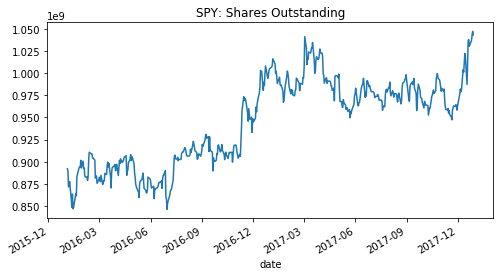

In [11]:
# Example: Shares Outstanding 
df = make_data(['SPY'])
df.xs('SPY',level='symbol')['2016':].so.plot(title='SPY: Shares Outstanding',figsize=(8,4))

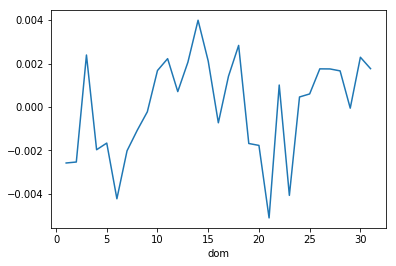

In [7]:
df['dow'] = df.index.get_level_values('date').weekday
df['dom'] = df.index.get_level_values('date').day
df['moy'] = df.index.get_level_values('date').month
df.groupby('dom').flow.mean().plot()

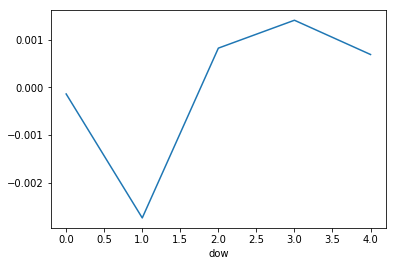

In [8]:
df.groupby('dow').flow.mean().plot()

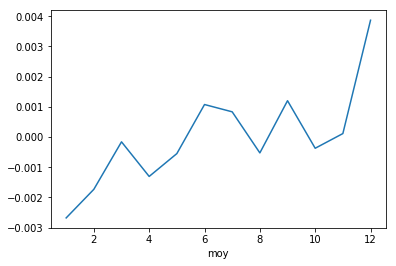

In [9]:
df.groupby('moy').flow.mean().plot()

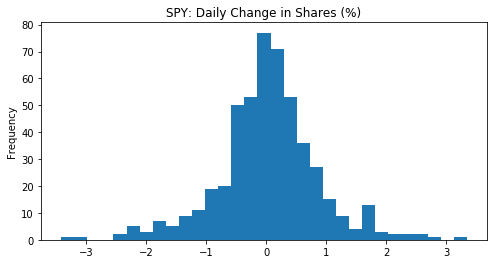

In [12]:
# Distribution of daily changes 
(df.xs('SPY',level='symbol')['2016':].flow*100.).rename('SPY').plot.hist(bins=31,
title='SPY: Daily Change in Shares (%)',figsize=(8,4))

## Step 2: Define the return formulas

Next, I'll define the formulas for "investment return" (i.e., time-weighted) and "investor return" (i.e., money-weighted).  `calc_investment_return` uses a mean of daily log returns to calculate the annualized geometric simple return.  

`calc_investor_return` is a bit more involved.  First, flows are normalized to the market capitalization at the beginning of the period (day 0).  We will calculate a hypothetical investor who contributes and redeems capital exactly as the market as a whole did.  This hypothetical investor's `basis` (i.e., cost basis) is calculated.   

Now, for the magic(1): the `avg_daily_log_ret` value is calculated as a weighted average of the daily log return series and the basis series (normalized by average basis).  In other words, if the example investor started with $100 basis and contributed $10 each day for the next 10 days, the return they earned on day 10 would be twice as important as the return they earned on day 1. 

Again, annualized log returns are converted to annualized simple returns for comparison.  

Note that, since both calculations are based on the same set of _dividend adjusted_, _net of fees_ returns, none of the difference between methods is attributable to fund costs or dividends.

I'll also create a function to compute and plot this behavior gap by year.  

(1) the precisely correct way to do money-weighted return is to use an IRR formula.  However, solving that formula for a 500, 1000, or 1500 period time series is computationally non-trivial.  I believe this method gives a quite close approximation.  Case in point, if we were to force the `flows` column to equal zero we get identical returns for investor and investment - exactly as we should.  

In [13]:
## Time-Weighted Return (aka Investment Return)
# Calculate average daily log return, annualize assuming 252 day year
# convert to simple returns

def calc_investment_return(df):
    avg_daily_ret_log = (df.log_ret_adj).mean() 
    annual_ret_log = avg_daily_ret_log*252
    annual_ret_simple = np.exp(annual_ret_log)-1
    return annual_ret_simple*100

def calc_investor_return(df):
    ''' Calculate the return for the full time period normalized for amount of capital deployed.
    '''
    # First, calculate the invested "basis" in terms of day 0 dollars.      
    adj_flows = df.flow*(df.mkt_cap_adj/df.mkt_cap_adj.iloc[0]) 
    adj_flows.iloc[0] = 1 # initial principal
    basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars

    # Adjust each day's returns 
    ## HERE'S THE MAGIC:
    avg_daily_log_ret = (df.log_ret_adj*basis / basis.mean()).mean()
    avg_annual_log_ret = avg_daily_log_ret*252
    avg_annual_simple_ret = np.exp(avg_annual_log_ret)-1
    
    return avg_annual_simple_ret*100

def compare_annual(df):
    symbols = df.index.get_level_values('symbol').unique().tolist()
    
    out = pd.DataFrame()
    for symbol in symbols:
        twr = df.xs(symbol,level='symbol').resample('A').apply(calc_investment_return)
        twr.name = 'twr'
        mwr = df.xs(symbol,level='symbol').resample('A').apply(calc_investor_return)
        mwr.name = 'mwr'
        days_in_year = df.xs(symbol,level='symbol').log_ret_adj.dropna().resample('A').count()
        
        both = pd.concat([twr,mwr],axis=1).reset_index().iloc[1:]

        both['symbol'] = symbol
        both.set_index(['date','symbol'],inplace=True)
        both['timing_impact'] = both.mwr - both.twr
        out = pd.concat([out,both],axis=0)
    return out

## Step 3: Apply to ETF Data
Once defined, these formulas are dead simple to apply.  We'll start by applying to four major equity index ETFs.  For each, we'll calculate an annualized return for the investment (time-weighted) and for the average investor (money-weighted), then difference these two values.  

A positive `behavior gap` means that investors, on average, actually beat the index by being more heavily allocated during upswings than declines.  

In [14]:
symbols = ['SPY','IWM','QQQ','VT']


df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

    investment investor behavior_gap
IWM    15.1263  13.0431     -2.08315
QQQ    21.4864  19.5639     -1.92247
SPY    15.1711  13.5852     -1.58587
VT     11.8944  11.5737    -0.320743


Here, we see significant behavior gaps for all funds, with possible exception of Vanguard Total World Index (VT).  Taking SPY as an example, the fund's annualized rate of return (net of fees, including dividends) was 15.17%.  However, the aggregate return of investors in SPY was 13.59%, a -1.58% difference!  

We can drill into this data by measuring each year's behavior gap.  In other words, the amount that investors, in aggregate, over/underperformed the fund's performance due to timing of inflows and outflows _within that year_.  

Text(0.5,1,'"Behavior Gap" By Fund (%)')

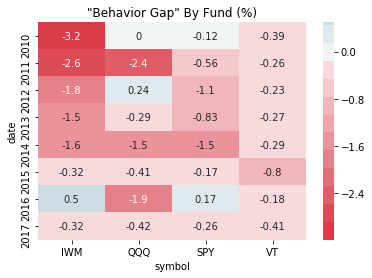

In [6]:
# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)

The negative behavior gap is fairly consistent, even when looking at the impact of flows _within_ a single year. This is, in my opinion, an important validation check which addresses [the major criticism](https://www.kitces.com/blog/does-the-dalbar-study-grossly-overstate-the-behavior-gap-guest-post/) of the DALBAR methodology, that it's skewed by long term trends in market returns.  

The astute observer will notice that the overall behavior gap is considerably higher than the average of the years.  For instance, SPY has an annualized behavior gap of -1.58% overall but no single year had a gap this wide.  Why? Because the by-year calculations only consider the flow of funds _within_ a given year, not across years.  

The one notable exception among this group of equity index ETFs is VT, the Vanguard Total World Stock Index.  Vanguard has the reputation for attracting buy-and-hold types, and the Total World Stock Index may be the most buy-and-hold-y of them all.  

Below is a chart of the average absolute daily fund flows (as a percent of fund value) for VT and SPY.  The main takeaway is that Vanguard investors aren't _better_ at timing the market, they're better at _not timing the market_!  

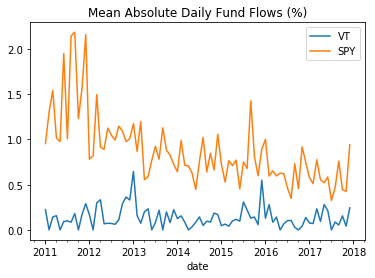

In [7]:
vt_daily_flow_abs = df.xs('VT',level='symbol').flow['2011':].abs().rename('VT') *100
spy_daily_flow_abs = df.xs('SPY',level='symbol').flow['2011':].abs().rename('SPY') *100

title = 'Mean Absolute Daily Fund Flows (%)'
vt_daily_flow_abs.resample('BM').mean().plot(legend=True,title=title)
spy_daily_flow_abs.resample('BM').mean().plot(legend=True)


Now that the methodology is in place, let's apply to a few different baskets of ETFs.

### Industry Sector
It's not uncommon for active investors to "rotate" between sectors based on perceived value or economic cycle.  Here, it appears that investor timing is much more problematic.  Sectors have, on average, a much larger behavior gap of -1.09%.  

    investment investor behavior_gap
XLB     14.147  12.1203     -2.02666
XLE    6.73684    1.523     -5.21383
XLI    16.4986  14.8231     -1.67549
XLK    19.1369   14.445      -4.6919
XLP    13.1754  11.3919     -1.78353
XLU    10.9491  8.20522     -2.74388
XLV    15.4375  12.4598     -2.97777
XLY    20.2254  14.2577     -5.96774


Text(0.5,1,'"Behavior Gap" By Fund (%)')

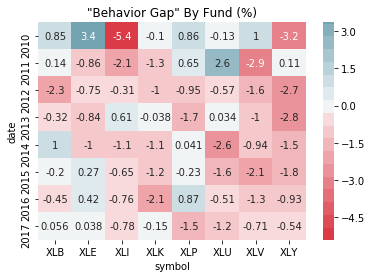

In [8]:
symbols = ['XLY','XLK','XLB','XLE','XLV','XLU','XLI','XLP']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


The behavior gap really intensifies when looking at sector funds, with an average annualized gap of almost 3.4% across funds.  

XLE, for instance, shows a behavior gap of more than 5% per year, reaching the ballpark of DALBAR's extraordinary finding.  This effect is entirely driven by year-to-year differences in funds.  As the chart below shows, cash poured into the sector in 2014, just as sector performance tanked.  

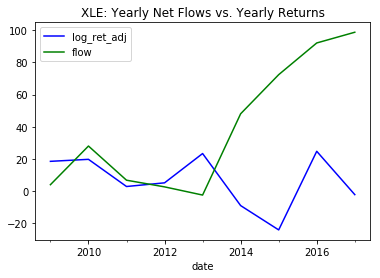

In [9]:
symbol = 'XLE'
(df.xs(symbol,level='symbol').log_ret_adj.resample('A').sum()*100).plot(legend=True,color='b',\
title='{}: Yearly Net Flows vs. Yearly Returns'.format(symbol))
(df.xs(symbol,level='symbol').flow.resample('A').sum()*100).cumsum().plot(legend=True,color='g')


Similar to sector funds, country/regional fund investors appear to be gifted for mis-timing markets.  As is often the case, the trade which "feels right", isn't.  


    investment investor behavior_gap
EEM    9.43172  8.33237     -1.09935
EWA    10.7659  8.47475     -2.29117
EWC    8.31316  5.43735      -2.8758
EWG    8.77191  5.78799     -2.98392
EWJ    6.72364  5.19998     -1.52366
FXI    7.77986  5.14926      -2.6306


Text(0.5,1,'"Behavior Gap" By Fund (%)')

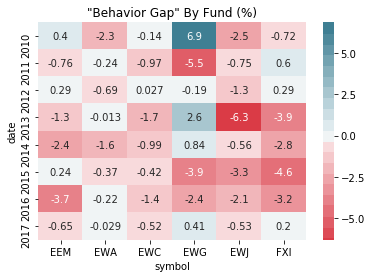

In [10]:
symbols = ['EWA','EWG','EWJ','EWC','FXI','EEM']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


Finally, I'll test the major bond ETFs.  Investor behavior strikes again!  It's notable that TLT (20+ year US treasury) is an exception to the rule, with investor returns meaningfully exceeding investment returns.  This is true despite the fact that TLT is among the highest inflow/outflow funds tested (almost 2x the rate of SPY).  

Perhaps bond investors truly are the "smart money".  

    investment investor behavior_gap
AGG    3.40971  2.76188    -0.647834
IEF    3.10948  2.40064    -0.708835
JNK    9.53539  6.47407     -3.06132
LQD    6.10281  5.35444    -0.748364
MUB    4.14828  2.47055     -1.67773
TLT    3.78433  5.28079      1.49646


Text(0.5,1,'"Behavior Gap" By Fund (%)\nWithin year')

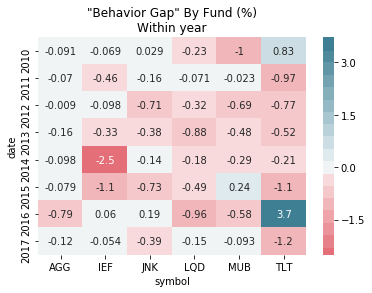

In [11]:
symbols = ['AGG','TLT','IEF','MUB','JNK','LQD']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)\nWithin year'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


### Summary

This post began as a rebuttal to DALBAR's questionable methodology and headline-grabbing results.  I have been surprised, however, at the scale and consistency of this effect on ETF investors.  

The most basic takeaway of this analysis is "Don't follow the herd".  The popular trade is, more often than not, the wrong trade.  This appears to be true with regard to overall market timing (risk-on, risk-off) as well as sector and asset class rotation strategies.

However, the second-level thinkers out there may take this as an invitation to time the market _against market sentiment_.  It's is admittedly easier said than done to buy junk bonds when everyone else "knows" they're doomed.  Yet, those who can do this are rewarded.

Regardless of which of these paths you choose to take, __fund flows__ are a necessary dataset to add to your toolkit.





### One last thing...
If you've found this post helpful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  

## Appendix

In [132]:
# backtest strategy
symbols = ['SPY','IWM','QQQ','VT','EWA','EWG','EWJ','EWC','FXI','EEM','AGG','TLT','IEF','MUB','JNK','LQD','XLY','XLK','XLB','XLE','XLV','XLU','XLI','XLP']
df = make_data(symbols)
df = df.dropna()


In [133]:
df['flow_20'] = df.groupby(level='symbol',group_keys=False).rolling(20).mean().flow.shift(2)
df['pct_rank_in_day'] = df.groupby(level='date').flow_20.rank(pct =True)
df['rank_in_day'] = df.groupby(level='date').flow_20.rank(pct =False,method='dense')

df['is_long'] = 0
df.loc[df.pct_rank_in_day<0.05,'is_long'] = 1 #big outflows
df['is_short'] = 0
df.loc[df.pct_rank_in_day>0.95,'is_short'] = 1 # big inflows


In [134]:
df.xs('SPY',level='symbol').dropna()

,close,so,close_adj,daily_ret_adj,weekly_ret_adj,monthly_ret_adj,log_ret_adj,flow,mkt_cap_adj,flow_20,pct_rank_in_day,rank_in_day,is_long,is_short
date,,,,,,,,,,,,,,
2009-01-02,92.960,1.040618e+06,76.239774,-0.001183,-0.041631,-0.099182,0.029697,-0.005080,7.933648e+07,-0.000621,0.391304,9.0,0,0
2009-01-05,92.850,1.052268e+06,76.149559,0.006677,-0.063543,-0.102531,-0.001184,0.011133,8.012974e+07,-0.000766,0.347826,8.0,0,0
2009-02-03,83.740,1.012459e+06,68.678127,-0.004896,-0.007523,-0.178409,0.013949,-0.001391,6.953379e+07,-0.001458,0.416667,10.0,0,0
2009-02-04,83.330,9.914086e+05,68.341872,0.014881,0.003240,-0.172927,-0.004908,-0.021011,6.775472e+07,-0.001302,0.500000,12.0,0,0
2009-02-05,84.570,9.846086e+05,69.358839,0.028485,-0.010760,-0.194632,0.014771,-0.006883,6.829131e+07,-0.001928,0.416667,10.0,0,0
2009-02-06,86.979,9.741086e+05,71.334545,0.001391,-0.048506,-0.170259,0.028087,-0.010721,6.948759e+07,-0.002910,0.291667,7.0,0,0
2009-02-09,87.100,9.628586e+05,71.433782,-0.045809,-0.090471,-0.166016,0.001390,-0.011616,6.878063e+07,-0.002908,0.333333,8.0,0,0
2009-02-10,83.110,9.516086e+05,68.161442,0.005896,-0.049092,-0.091565,-0.046892,-0.011753,6.486301e+07,-0.003633,0.208333,5.0,0,0
2009-02-11,83.600,9.495586e+05,68.563308,0.000718,-0.064821,-0.089833,0.005878,-0.002157,6.510488e+07,-0.003563,0.208333,5.0,0,0


In [143]:
df[df.is_long==1].monthly_ret_adj.mean()*100

1.1092594775795812

In [144]:
df[df.is_short==1].monthly_ret_adj.mean()*100

0.8436798943743854

In [141]:
df[(df.is_long==0) &(df.is_short==0)].weekly_ret_adj.mean()*10000

21.192938974040466

In [146]:
df.groupby('rank_in_day').monthly_ret_adj.count()

rank_in_day
1.0     2246
2.0     2249
3.0     2246
4.0     2251
5.0     2266
6.0     2289
7.0     2292
8.0     2293
9.0     2298
10.0    2293
11.0    2279
12.0    2282
13.0    2278
14.0    2269
15.0    2247
16.0    2242
17.0    2242
18.0    2242
19.0    2240
20.0    2237
21.0    2235
22.0    2229
23.0    2171
24.0    1885
Name: monthly_ret_adj, dtype: int64

Text(0.5,1,'Next Month Returns (%) by Decile of Fund Flows\nCross Sectional rank 24 Major Equity/Fixed Income Index ETFs (2009 to 2017)')

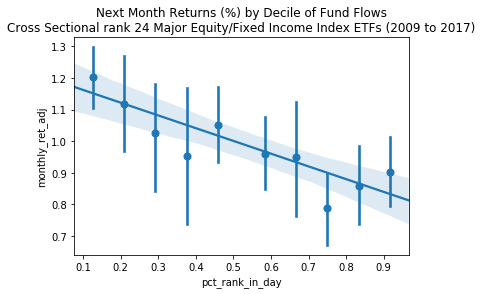

In [150]:
sns.regplot(df['pct_rank_in_day'],y=df['monthly_ret_adj']*100,x_bins=10)
plt.title('Next Month Returns (%) by Decile of Fund Flows\nCross Sectional rank 24 Major Equity/Fixed Income Index ETFs (2009 to 2017)')